In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [7]:
import pandas_datareader.data as web
import datetime as dt
st=dt.datetime(2015,1,29)
end=dt.datetime.today()
stock='GOOGL'
df=web.DataReader(stock,'yahoo',st,end)
#df.to_csv('stocks_forDASH.csv')

In [8]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-28,525.690002,512.349976,525.000000,512.429993,1791100,512.429993
2015-01-29,515.190002,503.480011,512.900024,513.229980,3950900,513.229980
2015-01-30,543.099976,518.179993,519.000000,537.549988,6055400,537.549988
2015-02-02,536.500000,521.719971,534.320007,532.200012,3768900,532.200012
2015-02-03,537.450012,526.809998,529.940002,533.299988,2353100,533.299988
...,...,...,...,...,...,...
2021-03-10,2061.399902,2019.329956,2061.399902,2036.189941,1353100,2036.189941
2021-03-11,2111.270020,2056.449951,2058.219971,2100.540039,1384200,2100.540039
2021-03-12,2077.610107,2032.420044,2076.409912,2050.000000,1690000,2050.000000


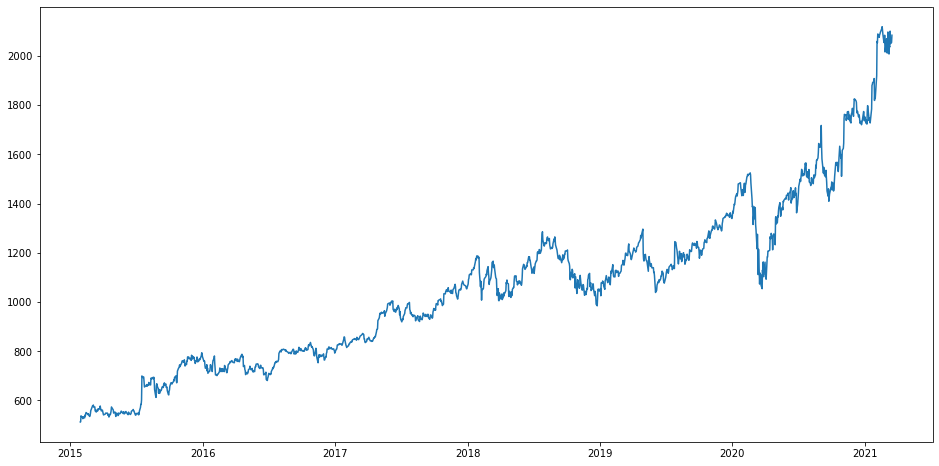

In [9]:
df["Date"]=pd.to_datetime(df.index,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [10]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Adj Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Adj Close"][i]=data["Adj Close"][i]
new_dataset

,Date,Adj Close
0,2015-01-28 00:00:00,512.43
1,2015-01-29 00:00:00,513.23
2,2015-01-30 00:00:00,537.55
3,2015-02-02 00:00:00,532.2
4,2015-02-03 00:00:00,533.3
...,...,...
1539,2021-03-10 00:00:00,2036.19
1540,2021-03-11 00:00:00,2100.54
1541,2021-03-12 00:00:00,2050
1542,2021-03-15 00:00:00,2054.44


In [11]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:1400,:]
valid_data=final_dataset[1400:,:]
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [12]:
x_train_data.shape

(1340, 60, 1)

In [13]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1340/1340 - 18s - loss: 0.0012


In [18]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [15]:
#valid_data

In [17]:
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(valid_data['Close'], valid_data['Predictions'])
rmse

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Plotting the predicted and closed prices

<ipython-input-82-4ed7aa3ec7de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


<function matplotlib.pyplot.show(close=None, block=None)>

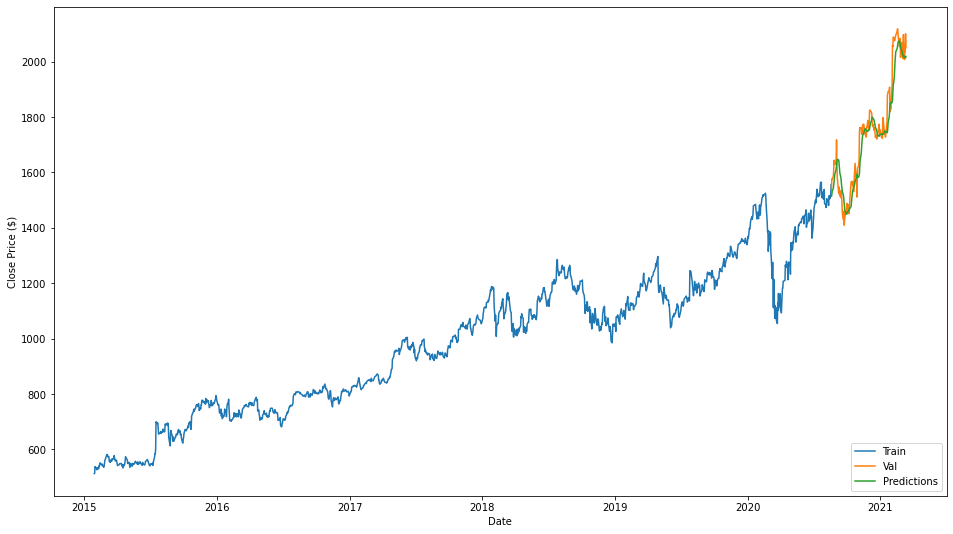

In [82]:
train_data=new_dataset[:1400]
valid_data=new_dataset[1400:]
valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(16,9))
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

plt.plot(train_data["Adj Close"])
plt.plot(valid_data[['Adj Close',"Predictions"]])

plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show

In [85]:
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(valid_data['Adj Close'], valid_data['Predictions'],squared=False)
rmse

59.73592769035181

In [ ]:
# prediction for next day

In [22]:
val=df.filter(['Adj Close'])

In [29]:
last_60=val[-60:].values
sc_last_60=scaler.transform(last_60)

X_test=[]
X_test.append(sc_last_60)
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=scaler.inverse_transform(lstm_model.predict(X_test))
pred

array([[1980.5265]], dtype=float32)

In [30]:
# price for next day

In [ ]:
X_test=[]
X_test.append(scaler.transform(val[-60:].values))